In [196]:
from utils import datasets
from utils.parser import * 
import os 
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import tensorflow as tf 
from models import * 
from utilities import *
from train_model_utilities import * 
import networkx as nx 
import tensorflow_addons as tfa 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [192]:
def get_structure_from_adajancency(adajancency):
    structure = np.zeros(adajancency.shape)
    g = nx.DiGraph(adajancency) # train.A is the matrix where the direct connections are stored 
    for i in range(len(adajancency)):
        ancestors = list(nx.descendants(g, i)) #here we need to use the function nx.descendants() because in the directed graph the edges have source from the descendant and point towards the ancestor 
        if ancestors:
            structure[i, ancestors] = 1
    return structure 

def mymax1(prob, structure):
    structure = (structure + np.eye(structure.shape[0])).astype(np.float32)
    structure = structure[np.newaxis,:,:]
    prob = prob[:,:,tf.newaxis]
    prob1 = tf.reduce_max(prob * structure, axis=1)
    return prob1

In [116]:
dataset_name = 'seq_FUN'
train, valid, test = initialize_dataset(dataset_name, datasets)
structure = get_structure_from_adajancency(train.A)

scalar = StandardScaler().fit(train.X)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean').fit(train.X)
train.X = scalar.transform(imputer.transform(train.X))
valid.X = scalar.transform(imputer.transform(valid.X))
test.X = scalar.transform(imputer.transform(test.X))

train.Y = tf.convert_to_tensor(train.Y, tf.float32)
valid.Y = tf.convert_to_tensor(valid.Y, tf.float32)
test.Y = tf.convert_to_tensor(test.Y, tf.float32)

train_data = tf.data.Dataset.from_tensor_slices(
    (tf.concat([train.X, valid.X],axis=0), tf.concat([train.Y, valid.Y],axis=0))
).shuffle(buffer_size = (train.X.shape[0]+valid.X.shape[0])).batch(batch_size=4)

# Traditional binary log loss without postprocessing

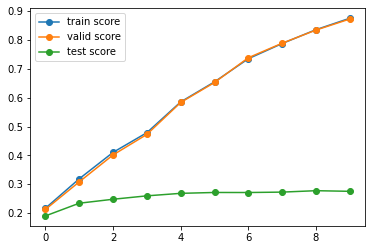

In [117]:
model = HMCModel(structure, 500, [2000,500], 0.5)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-5)

def loss_fn(y_true, y_logits):
    idx = tf.cast(tf.reduce_sum(y_true, axis=0) != y_true.shape[0], tf.float32) # remove root nodes
    loss = softplus(y_logits) + (1-y_true) * y_logits
    loss = tf.reduce_mean(loss * idx)
    return loss 

def train_a_step(model, optimizer, x_batch, y_batch):
    with tf.GradientTape() as tape:
        logits = model(x_batch)
        logits = model.postprocess(logits)
        loss = loss_fn(y_batch, logits)
        variables = model.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
    return loss 

def train_epochs(model, optimizer, train_data, epochs):
    steps = train.X.shape[0] // 4
    loss_list = []
    train_score_list = []
    valid_score_list = []
    test_score_list = []
    for epoch in range(epochs):
        loss = 0
        for x_batch, y_batch in train_data.take(steps):
            loss += train_a_step(model, optimizer, x_batch, y_batch)
        loss /= steps
        loss_list.append(loss) 
        train_score = custom_score(train.Y, model.predict(train.X))
        valid_score = custom_score(valid.Y, model.predict(valid.X))
        test_score = custom_score(test.Y, model.predict(test.X))
        train_score_list.append(train_score)
        valid_score_list.append(valid_score)
        test_score_list.append(test_score)
    return loss_list, train_score_list, valid_score_list, test_score_list

loss_list, train_score_list, valid_score_list, test_score_list = train_epochs(model, 
                                                                              optimizer, 
                                                                              train_data, 
                                                                              10)
plt.plot(train_score_list, '-o', label='train score')
plt.plot(valid_score_list, '-o', label = 'valid score')
plt.plot(test_score_list, '-o', label = 'test score')
plt.legend()

In [118]:
test_score_list

[0.19067685503404092,
 0.2346708920904348,
 0.24839293269397145,
 0.26019783870301805,
 0.26886834113803537,
 0.2718797434629962,
 0.2717309799896801,
 0.2731352417744636,
 0.278052481707452,
 0.27588343281482286]

# Postprocessing and MCM loss

In [193]:
class HMCModel(tf.keras.models.Model):
    def __init__(self, structure, num_classes, hid_dim_list, dropout):
        ''' 
        INPUT 
            structure           np.array, [M,M]
            num_classes         integer, M = num_classes
            hid_dim_list        a list of integers
        '''
        super(HMCModel, self).__init__()
        self.structure = structure
        self.num_hid_layers = len(hid_dim_list)
        
        self.W1 = list()
        self.dropout = tf.keras.layers.Dropout(dropout)
        for i in range(len(hid_dim_list)):
            self.W1.append(tf.keras.layers.Dense(hid_dim_list[i], activation='relu'))
        self.W2 = tf.keras.layers.Dense(num_classes, activation='sigmoid')
        
    def call(self, inputs):
        x = self.W1[0](inputs)
        for i in range(1, self.num_hid_layers):
            x = self.W1[i](x)
            x = self.dropout(x)
        outputs = self.W2(x)
        return outputs
    
    def postprocess(self, inputs):
        return mymax1(inputs, self.structure)
    
    def predict(self, inputs):
        prob = self.call(inputs)
        prob = mymax1(prob, self.structure)
        return prob

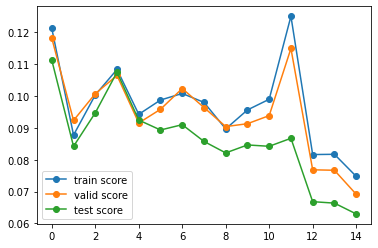

In [212]:
model = HMCModel(structure, 500, [2000,2000], 0.7)
optimizer = tf.optimizers.Adam(learning_rate=1e-4, decay=1e-5)

def mylog(x):
    x = tf.where(x < 1e-30, 1e-30, x)
    return tf.math.log(x)

def cross_y_log(y,prob):
    ''' return y * log(prob), to avoid 0 * log(0)'''
    r = tf.where(y != 0, y * mylog(prob), 0)
    return r 

def loss_fn(y_true, y_logits, structure):
    idx = tf.cast(tf.reduce_sum(y_true, axis=0) != y_true.shape[0], tf.float32) # remove root nodes
    prob = tf.nn.sigmoid(y_logits)
    part1 = - y_true * mylog(mymax1(prob * y_true, structure))
    part2 = - (1-y_true) * mylog(1 - mymax1(prob, structure))
    loss = part1 + part2
    loss = tf.reduce_mean(loss * idx)
    return loss 

def loss_fn_funny(y_true, prob, structure):
    idx = tf.squeeze(tf.where(tf.reduce_sum(y_true, axis=0) != y_true.shape[0])) # remove root nodes
    c_out = mymax1(prob, structure)
    t_out = y_true * prob
    t_out = mymax1(t_out, structure)
    t_out = (1-y_true) * c_out + y_true * t_out
    y_true1 = tf.gather(y_true, idx, axis=1)
    t_out1 = tf.gather(t_out, idx, axis=1)
    loss = tf.losses.BinaryCrossentropy(from_logits=False)(
        y_true1, t_out1
    )
    return loss

def train_a_step(model, optimizer, x_batch, y_batch, structure):
    with tf.GradientTape() as tape:
        prob = model(x_batch)
        loss = loss_fn_funny(y_batch, prob, structure)
        variables = model.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
    return loss 

def train_epochs(model, optimizer, train_data, epochs, structure):
    steps = (train.X.shape[0]+valid.X.shape[0]) // 4
    loss_list = []
    train_score_list = []
    valid_score_list = []
    test_score_list = []
    for epoch in range(epochs):
        loss = 0
        for x_batch, y_batch in train_data.take(steps):
            loss += train_a_step(model, optimizer, x_batch, y_batch, structure)
        loss /= steps
        loss_list.append(loss) 
        train_score = custom_score(train.Y, model.predict(train.X))
        valid_score = custom_score(valid.Y, model.predict(valid.X))
        test_score = custom_score(test.Y, model.predict(test.X))
        train_score_list.append(train_score)
        valid_score_list.append(valid_score)
        test_score_list.append(test_score)
    return loss_list, train_score_list, valid_score_list, test_score_list

loss_list, train_score_list, valid_score_list, test_score_list = train_epochs(model, 
                                                                              optimizer, 
                                                                              train_data, 
                                                                              15,
                                                                              structure)
plt.plot(train_score_list, '-o', label='train score')
plt.plot(valid_score_list, '-o', label = 'valid score')
plt.plot(test_score_list, '-o', label = 'test score')
plt.legend()

In [213]:
test_score_list

[0.1112721392041935,
 0.08420827000879846,
 0.09473276946519452,
 0.10750469688100672,
 0.09246146007298425,
 0.08933771499358091,
 0.09100676139155822,
 0.0857508703180666,
 0.08213950020501894,
 0.08464414342223131,
 0.08421734369769798,
 0.08672958340189765,
 0.06681709291611942,
 0.06636197846747274,
 0.06297026544479888]